In [196]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def add_basic_stats(row, moves, pref=""):
    row[pref + 'winrate_mean'] = np.mean(moves.winrate_delta)
    row[pref + 'score_mean'] = np.mean(moves.score_delta)
    row[pref + 'score_var'] = np.var(moves.score_delta)
    row[pref + 'selfplay_mean'] = np.mean(moves.selfplay_delta)
    row[pref + 'utility_mean'] = np.mean(moves.utility_delta)
    row[pref + 'winrate_beauty_percent'] = np.mean([x > 0 for x in moves.winrate_delta])
    row[pref + 'score_beauty_percent'] = np.mean([x > 0 for x in moves.score_delta])


def add_advanced_stats(row, moves, pref=""):
    moves.score_delta.sort()
    moves.winrate_delta.sort()

    row[pref + 'score25p'] = moves.score_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'score75p'] = moves.score_delta[int(moves.cnt_moves * 0.75)]
    row[pref + 'score_max'] = np.max(moves.score_delta)
    row[pref + 'score_min'] = np.min(moves.score_delta)
    row[pref + 'winrate25p'] = moves.winrate_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'winrate75p'] = moves.winrate_delta[int(moves.cnt_moves * 0.75)]

    row[pref + 'score_five_best_mean'] = np.mean(moves.score_delta[-5:])
    row[pref + 'score_five_worst_mean'] = np.mean(moves.score_delta[:5])

    row[pref + 'stddev_last'] = moves.stddev_delta[-1]
    moves.stddev_delta.sort()
    row[pref + 'stddev_mean'] = np.mean(moves.stddev_delta)
    row[pref + 'stddev50p'] = moves.stddev_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'score50p'] = moves.score_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'winrate_midmean'] = np.mean(
        moves.winrate_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])
    row[pref + 'score_midmean'] = np.mean(moves.score_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])


def get_int_from_rank(rank):
    if rank[1] == 'k':
        return -int(rank[0]) + 1
    else:
        return int(rank[0])


def get_rank_from_int(x):
    if x > 0:
        return str(x) + "d"
    else:
        return str(-x + 1) + "k"


def add_meta(row):
    if row['Result'] == '?':
        row['game_result'] = 0
    else:
        row['game_result'] = int(row['Result'])
    row['rank'] = get_int_from_rank(row['W_rating'])
    row['game_length'] = len(row['W_move']) + len(row['B_move'])


def convert_to_lists(df):
    for i, row in tqdm(df.iterrows()):
        row['W_scoreLead'] = [float(x) for x in row['W_scoreLead'].split()]
        row['B_scoreLead'] = [float(x) for x in row['B_scoreLead'].split()]
        row['W_scoreSelfplay'] = [float(x) for x in row['W_scoreSelfplay'].split()]
        row['B_scoreSelfplay'] = [float(x) for x in row['B_scoreSelfplay'].split()]
        row['W_scoreStdev'] = [float(x) for x in row['W_scoreStdev'].split()]
        row['B_scoreStdev'] = [float(x) for x in row['B_scoreStdev'].split()]
        row['W_utility'] = [float(x) for x in row['W_utility'].split()]
        row['B_utility'] = [float(x) for x in row['B_utility'].split()]
        row['W_winrate'] = [float(x) for x in row['W_winrate'].split()]
        row['B_winrate'] = [float(x) for x in row['B_winrate'].split()]


class MovesInfo:
    def __init__(self, row, n_moves=None, player='W'):
        enemy = 'B' if player == 'W' else 'W'
        moves_len = min(len(row[player + '_winrate']), len(row[enemy + '_winrate']))
        if n_moves is None:
            start_ind = 0
        else:
            start_ind = max(moves_len - n_moves - 1, 0)

        end_ind = moves_len
        self.winrate_delta = np.array(row[player + '_winrate'][start_ind:end_ind]) - np.array(
            row[enemy + '_winrate'][start_ind:end_ind])
        self.score_delta = np.array(row[player + '_scoreLead'][start_ind:end_ind]) - np.array(
            row[enemy + '_scoreLead'][start_ind:end_ind])
        self.utility_delta = np.array(row[player + '_utility'][start_ind:end_ind]) - np.array(
            row[enemy + '_utility'][start_ind:end_ind])
        self.selfplay_delta = np.array(row[player + '_scoreSelfplay'][start_ind:end_ind]) - np.array(
            row[enemy + '_scoreSelfplay'][start_ind:end_ind])
        self.stddev_delta = np.array(row[player + '_scoreStdev'][start_ind:end_ind]) - np.array(
            row[enemy + '_scoreStdev'][start_ind:end_ind])
        self.move = row[player + '_move'].split()
        self.cnt_moves = end_ind - start_ind


def add_all_game_stats(df):
    df['winrate_mean'] = None
    df['score_midmean'] = None
    df['score_mean'] = None
    df['score_var'] = None
    df['winrate_beauty_percent'] = None
    df['score_beauty_percent'] = None
    df['utility_mean'] = None
    df['score25p'] = None
    df['score75p'] = None
    df['winrate25p'] = None
    df['winrate75p'] = None
    df['winrate_midmean'] = None
    df['score50p'] = None
    df['game_length'] = None
    df['rank'] = None
    df['game_result'] = None
    df['selfplay_mean'] = None
    df['stddev_mean'] = None
    df['stddev50p'] = None
    df['stddev_last'] = None
    df['score_max'] = None
    df['score_min'] = None
    df['score_five_best_mean'] = None
    df['score_five_worst_mean'] = None

    for i, row in tqdm(df.iterrows()):
        add_meta(row)
        add_basic_stats(row, MovesInfo(row))
        add_advanced_stats(row, MovesInfo(row))


def get_start_of_yose(margin_moves, no_change_count=5):
    '''
    Находим сколько последних ходов мы будем считать что это йосе

    Будем идти с конца по массиву количества ходов на краю, если в массиве no_change_count одинаковых чисел,
    то мы останавливаемся и говорим, что тут началось йосе
    '''
    no_change = 1
    ans = len(margin_moves)
    for i in range(len(margin_moves) - 2, -1, -1):
        if margin_moves[i] == margin_moves[i + 1]:
            no_change += 1
        else:
            no_change = 1
        if no_change >= no_change_count:
            ans = len(margin_moves) - i - 1
            break
    return ans


def reset_basic_stats(df, pref):
    df[pref + 'winrate_mean'] = None
    df[pref + 'winrate_beauty_percent'] = None
    df[pref + 'score_beauty_percent'] = None
    df[pref + 'score_mean'] = None
    df[pref + 'selfplay_mean'] = None
    df[pref + 'score_var'] = None
    df[pref + 'utility_mean'] = None


def is_marginal_move(move):
    return (move[0] == 'a' or move[0] == 'b') or (move[0] == 'r' or move[0] == 's') or \
           (move[1] == 'a' or move[1] == 'b') or (move[1] == 'r' or move[1] == 's')


def count_of_marginal_moves(moves):
    ans = np.zeros(len(moves))
    for i in range(len(moves)):
        ans[i] = is_marginal_move(moves[i])
    ans = np.cumsum(ans)
    return ans


def add_yose_stats(df):
    pref = 'yose_'
    reset_basic_stats(df, pref)
    df['yose_length'] = None
    df['yose_start'] = None
    df['yose_has'] = None
    for i, row in tqdm(df.iterrows()):
        marginal_moves = count_of_marginal_moves(row['W_move'].split())
        n_moves = get_start_of_yose(marginal_moves, 10)
        add_basic_stats(row, MovesInfo(row, n_moves), pref)
        row['yose_length'] = n_moves
        row['yose_start'] = len(row['W_move'].split()) - n_moves
        row['yose_has'] = row['yose_start'] != 0


def delta_moves(a, b):
    return abs(ord(a[0]) - ord(b[0])) + abs(ord(a[1]) - ord(b[1]))


def get_distance_of_moves(moves):
    ans = np.zeros(len(moves) - 1)
    for i in range(1, len(moves)):
        ans[i - 1] = delta_moves(moves[i], moves[i - 1])
    return ans


def get_distance_from_enemy(my_moves, enemy_moves):
    ans = np.zeros(min(len(my_moves), len(enemy_moves)))
    for i in range(min(len(my_moves), len(enemy_moves))):
        ans[i] = delta_moves(my_moves[i], enemy_moves[i])
    return ans


def add_last_moves_stats(df, n_moves, pref=None):
    if pref is None:
        pref = str(n_moves) + "_"
    reset_basic_stats(df, pref)
    for i, row in tqdm(df.iterrows()):
        add_basic_stats(row, MovesInfo(row, n_moves), pref)


def add_dist_stats_to_row(row):
    dist = get_distance_of_moves(row['W_move'].split())
    dist_enemy = get_distance_from_enemy(row['W_move'].split(), row['B_move'].split())
    dist.sort()

    row['dist_mean'] = np.mean(dist)
    row['dist_var'] = np.var(dist)
    row['dist_median'] = dist[len(dist) // 2]
    row['dist_procent_more_than_10'] = np.mean([x > 10 for x in dist])
    row['dist_procent_more_than_5'] = np.mean([x > 5 for x in dist])
    row['dist_procent_more_than_20'] = np.mean([x > 20 for x in dist])

    row['dist_from_enemy_mean'] = np.mean(dist_enemy)
    row['dist_from_enemy_var'] = np.var(dist_enemy)


def add_dist_stats(df):
    df['dist_mean'] = None
    df['dist_var'] = None
    df['dist_median'] = None
    df['dist_procent_more_than_5'] = None
    df['dist_procent_more_than_10'] = None
    df['dist_procent_more_than_20'] = None

    df['dist_from_enemy_mean'] = None
    df['dist_from_enemy_var'] = None

    for i, row in tqdm(df.iterrows()):
        add_dist_stats_to_row(row)


def delete_non_scalar_parameters(df):
    df.drop(['W_rating', 'B_rating', 'W_move', 'B_move', 'W_scoreLead', 'B_scoreLead', 'W_scoreSelfplay',
             'B_scoreSelfplay', 'W_scoreStdev', 'B_scoreStdev', 'W_utility', 'B_utility', 'W_visits', 'B_visits',
             'W_winrate', 'B_winrate', 'Result'], axis=1, inplace=True)


def add_delta_lists_to_row(row, moves):
    row['winrate'] = moves.winrate_delta
    row['score'] = moves.score_delta
    row['winrate_sqr'] = np.array([x ** 2 for x  in moves.winrate_delta])
    row['score_sqr'] = np.array([x ** 2 for x  in moves.score_delta])
    row['utility'] = moves.utility_delta
    row['selfplay'] = moves.selfplay_delta
    row['stddev'] = moves.stddev_delta
    row['dist_from_prev'] = get_distance_of_moves(moves.move)
    row['dist_more_5'] = [int(x > 5) + 1 for x in row['dist_from_prev']]


def add_lists_to_df(df):
    df['winrate'] = None
    df['score'] = None
    df['utility'] = None
    df['selfplay'] = None
    df['stddev'] = None
    df['dist_from_prev'] = None
    df['rank'] = None
    df['game_length'] = None
    df['score_sqr'] = None
    df['winrate_sqr'] = None
    df['dist_more_5'] = None
    for i, row in tqdm(df.iterrows()):
        add_meta(row)
        add_delta_lists_to_row(row, MovesInfo(row))


def get_feature_df(df):
    convert_to_lists(df)
    add_all_game_stats(df)
    add_yose_stats(df)
    add_last_moves_stats(df, 10)
    add_last_moves_stats(df, 20)
    add_dist_stats(df)
    delete_non_scalar_parameters(df)
    return df


def get_df_with_lists(df):
    convert_to_lists(df)
    add_all_game_stats(df)
    add_last_moves_stats(df, 20)
    add_dist_stats(df)
    add_lists_to_df(df)
    delete_non_scalar_parameters(df)
    return df


In [197]:
from google.colab import drive
drive.mount('/content/drive')
katago = pd.read_csv('/content/drive/MyDrive/data_katago.csv')
katago.dropna(how = 'any', inplace= True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
katago_new = get_df_with_lists(katago)

144204it [01:30, 1591.56it/s]
144204it [02:51, 842.06it/s]
144204it [01:02, 2319.71it/s]
144204it [01:49, 1315.17it/s]
144204it [01:56, 1234.53it/s]


In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(katago_new, katago_new['rank'] + 5, test_size=4)

In [239]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

class RnnKerasRunner:
    __DEFAULT_FEATURES = ['score', 'winrate', 'utility', 'stddev', 'selfplay', 'dist_from_prev', 'winrate_sqr', 'score_sqr', 'dist_more_5']

    def __create_rnn(self, hidden_units, input_shape):
        model = keras.Sequential()
        # model.add(layers.Embedding(input_dim=6, output_dim=6))
        model.add(tf.keras.layers.Masking(mask_value=0.,
                                          input_shape=input_shape))
        #model.add(layers.BatchNormalization())
        model.add(layers.Bidirectional(layers.LSTM(hidden_units)))  # , dropout = 0.15, reccurent_dropout = 0.15)))
        model.add(layers.Dense(units=15, activation="linear"))
        model.add(layers.Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
        return model

    def __init__(self, model = None, sequence_len=150, features=__DEFAULT_FEATURES):
        self.features = features
        self.sequence_len = sequence_len
        if model is None:
            self.model = self.__create_rnn(64, (sequence_len, len(features)))
        else:
            self.model = model

    def __get_tensor(self, df):

        def resize_to_length(m, length):
            if len(m) > length:
                return m[:length]
            n_nules = length - len(m)
            return list([0] * n_nules) + list(m)

        arr = []
        for feature in self.features:
            arr.append([np.array(y) for y in df[feature].apply(lambda x : resize_to_length(x, self.sequence_len))])
        arr = np.array(arr)
        arr = arr.swapaxes(0, 1)
        arr = arr.swapaxes(1, 2)
        return tf.convert_to_tensor(arr, np.float32)

    def fit(self, df, target, epochs=10, batch_size=256):
        X = self.__get_tensor(df)
        y = to_categorical(target, num_classes=15) 
        self.model.fit(X, y, epochs=epochs, batch_size = batch_size)

    def predict(self, df):
        X = self.__get_tensor(df)
        return self.model.predict(X)

In [240]:
from keras.models import load_model
#model_ready = RnnKerasRunner(load_model('/content/drive/MyDrive/model6k-9d_normal-up.h5'))
model_my = RnnKerasRunner(sequence_len = 250)

from sklearn.model_selection import train_test_split

In [241]:
model_my.fit(X_train, tf.convert_to_tensor(y_train, np.int32), epochs = 3, batch_size = 32)

Epoch 1/3
313/313 [==============================] - 115s 343ms/step - loss: 2.4853 - accuracy: 0.1297
Epoch 2/3
313/313 [==============================] - 117s 375ms/step - loss: 2.3863 - accuracy: 0.1518
Epoch 3/3
313/313 [==============================] - 118s 378ms/step - loss: 2.3434 - accuracy: 0.1561


In [253]:
y = model_my.predict(X_train)


In [255]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y.argmax(axis = 1), y_train))

2.5031012404961985


In [229]:
tf.convert_to_tensor(y_train, np.int32)

<tf.Tensor: shape=(144200,), dtype=int32, numpy=array([ 3,  7,  2, ...,  3,  2, 13], dtype=int32)>

In [201]:
from sklearn.metrics import mean_absolute_error
X_test = katago_new
y_test = katago['rank']
ans_ready = model_ready.predict(X_test)
#ans_my = model_my.predict(X_test)
print(mean_absolute_error(np.round(ans_ready), y_test))
#print(mean_absolute_error(np.round(ans_my), y_test))
print(ans_ready)

1.9784125266982886
[[-1.1598206 ]
 [ 3.9157317 ]
 [ 1.2092077 ]
 ...
 [-0.60294986]
 [ 4.442478  ]
 [-1.889571  ]]


In [205]:
print(ans_ready)

[[-1.]
 [ 4.]
 [ 1.]
 ...
 [-1.]
 [ 4.]
 [-2.]]


In [207]:
y_test = np.array(y_test)

In [172]:
print(np.mean(ans_ready), np.mean(y_test))

1.8304137 1.78425


In [203]:
ans_ready = np.round(ans_ready)

In [208]:
for error in range(-5, 6):
  cnt  = 0
  for i in range(len(y_test)):
    if ans_ready[i] - y_test[i] == error:
      cnt += 1
  print('Процент, когда мы предсказываем ранг на ', error, ' больше, чем он есть на самом деле: ', cnt / len(y_test) * 100)

Процент, когда мы предсказываем ранг на  -5  больше, чем он есть на самом деле:  1.690660453246789
Процент, когда мы предсказываем ранг на  -4  больше, чем он есть на самом деле:  3.6455299436908826
Процент, когда мы предсказываем ранг на  -3  больше, чем он есть на самом деле:  7.166236720201937
Процент, когда мы предсказываем ранг на  -2  больше, чем он есть на самом деле:  12.396327425036754
Процент, когда мы предсказываем ранг на  -1  больше, чем он есть на самом деле:  16.549471581925605
Процент, когда мы предсказываем ранг на  0  больше, чем он есть на самом деле:  15.917727663587694
Процент, когда мы предсказываем ранг на  1  больше, чем он есть на самом деле:  13.536379018612521
Процент, когда мы предсказываем ранг на  2  больше, чем он есть на самом деле:  11.063493384372139
Процент, когда мы предсказываем ранг на  3  больше, чем он есть на самом деле:  7.886050317605614
Процент, когда мы предсказываем ранг на  4  больше, чем он есть на самом деле:  4.449252447921001
Процент, 

In [209]:
for error in range(0, 4):
  cnt  = 0
  for i in range(len(y_test)):
    if abs(ans_ready[i] - y_test[i]) <= error:
      cnt += 1
  print('Процент, когда мы предсказываем ранг с точностью до ', error, ' рангов, равен: ', cnt / len(y_test) * 100)

Процент, когда мы предсказываем ранг с точностью до  0  рангов, равен:  15.917727663587694
Процент, когда мы предсказываем ранг с точностью до  1  рангов, равен:  46.00357826412582
Процент, когда мы предсказываем ранг с точностью до  2  рангов, равен:  69.46339907353472
Процент, когда мы предсказываем ранг с точностью до  3  рангов, равен:  84.51568611134228


In [210]:
maes = []
for rnk in range(-5, 10):
  rz = []
  for i in range(len(y_test)):
    if y_test[i] == rnk:
      rz.append(abs(ans_ready[i] - y_test[i]))
  print('Для ранга ', get_rank_from_int(rnk), ' MAE равно ', np.mean(rz))
  maes.append(np.mean(rz))

Для ранга  6k  MAE равно  3.7811015
Для ранга  5k  MAE равно  2.8834903
Для ранга  4k  MAE равно  2.3768442
Для ранга  3k  MAE равно  1.451
Для ранга  2k  MAE равно  1.3232
Для ранга  1k  MAE равно  1.4975
Для ранга  1d  MAE равно  1.7455746
Для ранга  2d  MAE равно  1.8690869
Для ранга  3d  MAE равно  1.9266
Для ранга  4d  MAE равно  1.8113
Для ранга  5d  MAE равно  1.6396
Для ранга  6d  MAE равно  1.5394
Для ранга  7d  MAE равно  1.7049
Для ранга  8d  MAE равно  1.9699839
Для ранга  9d  MAE равно  2.436973


In [215]:
print(np.mean(maes[3:-2]))

1.6508162


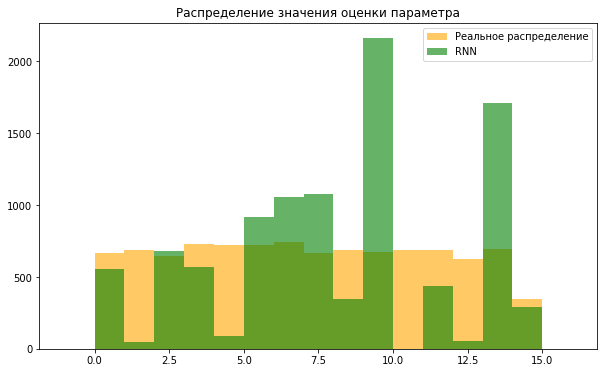

In [256]:
from matplotlib import pyplot as plt
bins = [i + -1.001 for i in range(18)]
plt.figure(figsize=(10, 6))
plt.title("Распределение значения оценки параметра")
plt.hist(
    y_train,
    bins = bins,
    alpha = 0.6,
    color = 'orange',
    label = 'Реальное распределение'
)
plt.hist(
    y.argmax(axis = 1),
    bins = bins,
    alpha = 0.6,
    color = 'green',
    label = 'RNN'
)
plt.legend()
plt.show()

In [ ]:
plt.plot(x = [get_rank_from_int(x) for x in (range(-5, 10))], y = maes)

plt.show()